# Import Packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

# Steps

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Camera Calibration

Text(0.5, 1.0, 'undistorted calibration1.jpg')

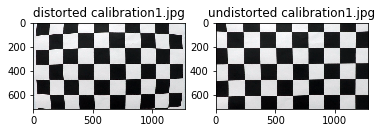

In [19]:
# Create function to return image and object points for an image
def get_cal_points(image,nx,ny):
    
    # Debugplot flag
    debugplot = False
    
    # Initialize image and object points to empty
    objp = []
    imgp = []
    
    # Convert to grayscale
    image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    
    # Find chessboard corners
    ret, corners = cv2.findChessboardCorners(image_gray, (nx, ny), None)
    
    # If found, update image and object points
    if ret == True:
        objp = np.zeros((nx*ny,3),np.float32)
        objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
        imgp = corners
        
        # Debugplot
        if debugplot:
            plt.figure()
            cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
            plt.imshow(image)
    
    return ret,objp,imgp

# Initialize arrays to store all image and object points
objpoints = []
imgpoints = []

# Go through each file and obtain object and image points
files = os.listdir("camera_cal/")
nx = 9
ny = 6
for file in files:
    image = cv2.imread('camera_cal/' + file)
    ret,objp,imgp = get_cal_points(image,nx,ny)
    if ret:
        objpoints.append(objp)
        imgpoints.append(imgp)

# Obtain camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image.shape[1::-1], None, None)

# Undistort an image as an example
file_num = 6
image = cv2.imread('camera_cal/' + files[file_num])
undist = cv2.undistort(image, mtx, dist, None,mtx)
plt.subplot(1,2,1)
plt.imshow(image)
plt.title('distorted '+files[file_num])
plt.subplot(1,2,2)
plt.imshow(undist)
plt.title('undistorted '+files[file_num])

